### Initial Hotspot Prediction Model
##### Goal: Identify high-demand zones at specific times, based on historical trip pickup patterns


#### Load Trip Data

In [2]:
import os
from datetime import datetime
from collections import Counter
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from shapely.geometry import Polygon

from sklearn.model_selection import (
    KFold, train_test_split, GridSearchCV
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, accuracy_score
)

import lightgbm as lgb
from lightgbm import (
    early_stopping, log_evaluation,
    LGBMRegressor, plot_importance
)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor


In [3]:
jan_df = pd.read_csv('/Users/elliekavanagh/Downloads/Clean_Jan_taxi.csv')
feb_df = pd.read_csv('/Users/elliekavanagh/Downloads/Clean_Feb_Taxi.csv')

# Combine them
df = pd.concat([jan_df, feb_df], ignore_index=True)

print("Initial shape:", df.shape)
print(f"Columns: {list(df.columns)}")

Initial shape: (5609910, 25)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'service_zone', 'fare_per_minute', 'fare_per_mile', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend', 'is_airport_pickup', 'is_airport_dropoff', 'is_airport_trip']


#### Preprocessing: Creating Datetime Features and Dropping Features

In [4]:
# Convert date columns to datetime
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [5]:
us_holidays = holidays.UnitedStates(years=[2023])
holiday_dates = list(us_holidays.keys())  

df['is_holiday'] = df['tpep_pickup_datetime'].dt.date.isin(holiday_dates)

In [6]:
# Add pickup month
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
# Add pickup minute
df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute

In [7]:
df['day_time_interaction'] = df['pickup_day_of_week'].astype(str) + "_" + df['time_of_day'].astype(str)
df['zone_hour_interaction'] = df['pickup_zone'].astype(str) + "_" + df['pickup_hour'].astype(str)
df['holiday_time_interaction'] = df['is_holiday'].astype(str) + '_' + df['time_of_day'].astype(str)
df['zone_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['is_weekend'].astype(str)
df['hour_isweekend_interaction'] = df['pickup_hour'].astype(str) + '_' + df['is_weekend'].astype(str)
df['zone_time_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['time_of_day'].astype(str) + "_" + df['is_weekend'].astype(str)
df['zone_hour_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['pickup_hour'].astype(str) + "_" + df['is_weekend'].astype(str)
df['zone_hour_holiday_interaction'] = df['pickup_zone'].astype(str) + '_' + df['pickup_hour'].astype(str) + "_" + df['is_holiday'].astype(str)

In [8]:
# Drop the below features - Not needed for classifying a zone as a hotspot
columns_to_drop = [
    'fare_amount', 'fare_per_minute', 'trip_distance', 'trip_speed', 'trip_duration_min', 'dropoff_borough', 'dropoff_zone',
    'droppoff_date', 'trip_speed_mph'
]
df.drop(columns=columns_to_drop, inplace=True)

**Discussion:** Drop post-trip features such as fare_amount and trip_duration_min, as they aren't know at prediction time.

#### Aggregating Trips By Zone, Pickup Time, and Day of Week

In [9]:
trip_counts = df.groupby(['pickup_date', 'pickup_hour', 'pickup_zone', 'pickup_borough', 'day_type', 'pickup_month', 'day_time_interaction', 
                          'zone_hour_interaction', 'zone_isweekend_interaction', 'holiday_time_interaction', 'hour_isweekend_interaction', 
                          'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction', 'zone_hour_holiday_interaction', 'pickup_day_of_week', 'is_weekend', 'time_of_day', 'is_holiday']).size().reset_index(name='trip_count')
trip_counts = trip_counts.sort_values(by=['pickup_date', 'pickup_hour'], ascending=[True, True])
trip_counts

,pickup_date,pickup_hour,pickup_zone,pickup_borough,day_type,pickup_month,day_time_interaction,zone_hour_interaction,zone_isweekend_interaction,holiday_time_interaction,hour_isweekend_interaction,zone_time_isweekend_interaction,zone_hour_isweekend_interaction,zone_hour_holiday_interaction,pickup_day_of_week,is_weekend,time_of_day,is_holiday,trip_count
0,2023-01-01,0,Alphabet City,Manhattan,Weekend,1,6_Early Morning,Alphabet City_0,Alphabet City_True,True_Early Morning,0_True,Alphabet City_Early Morning_True,Alphabet City_0_True,Alphabet City_0_True,6,True,Early Morning,True,19
1,2023-01-01,0,Astoria,Queens,Weekend,1,6_Early Morning,Astoria_0,Astoria_True,True_Early Morning,0_True,Astoria_Early Morning_True,Astoria_0_True,Astoria_0_True,6,True,Early Morning,True,3
2,2023-01-01,0,Battery Park,Manhattan,Weekend,1,6_Early Morning,Battery Park_0,Battery Park_True,True_Early Morning,0_True,Battery Park_Early Morning_True,Battery Park_0_True,Battery Park_0_True,6,True,Early Morning,True,1
3,2023-01-01,0,Battery Park City,Manhattan,Weekend,1,6_Early Morning,Battery Park City_0,Battery Park City_True,True_Early Morning,0_True,Battery Park City_Early Morning_True,Battery Park City_0_True,Battery Park City_0_True,6,True,Early Morning,True,14
4,2023-01-01,0,Bloomingdale,Manhattan,Weekend,1,6_Early Morning,Bloomingdale_0,Bloomingdale_True,True_Early Morning,0_True,Bloomingdale_Early Morning_True,Bloomingdale_0_True,Bloomingdale_0_True,6,True,Early Morning,True,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121742,2023-02-28,23,Williamsburg (North Side),Brooklyn,Weekday,2,1_Night,Williamsburg (North Side)_23,Williamsburg (North Side)_False,False_Night,23_False,Williamsburg (North Side)_Night_False,Williamsburg (North Side)_23_False,Williamsburg (North Side)_23_False,1,False,Night,False,1
121743,2023-02-28,23,Williamsburg (South Side),Brooklyn,Weekday,2,1_Night,Williamsburg (South Side)_23,Williamsburg (South Side)_False,False_Night,23_False,Williamsburg (South Side)_Night_False,Williamsburg (South Side)_23_False,Williamsburg (South Side)_23_False,1,False,Night,False,1
121744,2023-02-28,23,World Trade Center,Manhattan,Weekday,2,1_Night,World Trade Center_23,World Trade Center_False,False_Night,23_False,World Trade Center_Night_False,World Trade Center_23_False,World Trade Center_23_False,1,False,Night,False,15
121745,2023-02-28,23,Yorkville East,Manhattan,Weekday,2,1_Night,Yorkville East_23,Yorkville East_False,False_Night,23_False,Yorkville East_Night_False,Yorkville East_23_False,Yorkville East_23_False,1,False,Night,False,9


In [10]:
trip_counts = trip_counts.sort_values(['pickup_zone', 'pickup_hour'])
trip_counts.columns

Index(['pickup_date', 'pickup_hour', 'pickup_zone', 'pickup_borough',
       'day_type', 'pickup_month', 'day_time_interaction',
       'zone_hour_interaction', 'zone_isweekend_interaction',
       'holiday_time_interaction', 'hour_isweekend_interaction',
       'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction',
       'zone_hour_holiday_interaction', 'pickup_day_of_week', 'is_weekend',
       'time_of_day', 'is_holiday', 'trip_count'],
      dtype='object')

**Creating lag/rolling features:** 
Lag and rolling features capture temporal dependecies by only using past data to predict current demand.

**Key steps:**
1. Combine date and hour (datetime) to order the data chronologically
2. Sort data by zone and datetime to ensure lag/rolling features only refer to earlier time points within each zone
3. Create lag features:
    - trip_count_1h_ago uses the trip count from 1 hour prior
    - trip_count_2h_ago uses the trip count from 2 hours prior
Because these features reference past trip counts, the model can't access future information (preventing leakage)
4. Calculate rolling averages:
    - rolling_avg_1h is based only on the previous hour
    - rolling_avg_2h averages the two prior hours
Rolling averages are also computed only using historical data, ensuring no current or forward-looking data is included
5. Handle missing lag values: Missing lag values are filled with zeros, maintaining dataset integrity without leaking future data

**Avoiding data leakage:**
By sorting trip_counts by datetime within each zone, the lag and rolling features are calculated using only past trip counts. This ensures that when the model sees data for a gifen hour, it does not have access to any information from the current or future hours, preventing data leakage.

In [11]:
trip_counts['datetime'] = pd.to_datetime(trip_counts['pickup_date']) + pd.to_timedelta(trip_counts['pickup_hour'], unit='h')
trip_counts = trip_counts.sort_values(['pickup_zone', 'datetime']).reset_index(drop=True)

# Create lag features (past trip counts)
trip_counts['trip_count_1h_ago'] = trip_counts.groupby('pickup_zone')['trip_count'].shift(1).fillna(0)
trip_counts['trip_count_2h_ago'] = trip_counts.groupby('pickup_zone')['trip_count'].shift(2).fillna(0)

# Rolling average for past 2 hours
trip_counts['rolling_avg_2h'] = (trip_counts['trip_count_1h_ago'] + trip_counts['trip_count_2h_ago']) / 2

trip_counts = trip_counts.drop(['datetime'], axis=1)

In [12]:
trip_counts = trip_counts.sort_values(['trip_count'], ascending=False)
trip_counts

,pickup_date,pickup_hour,pickup_zone,pickup_borough,day_type,pickup_month,day_time_interaction,zone_hour_interaction,zone_isweekend_interaction,holiday_time_interaction,...,zone_hour_isweekend_interaction,zone_hour_holiday_interaction,pickup_day_of_week,is_weekend,time_of_day,is_holiday,trip_count,trip_count_1h_ago,trip_count_2h_ago,rolling_avg_2h
31490,2023-01-22,1,East Village,Manhattan,Weekend,1,6_Early Morning,East Village_1,East Village_True,False_Early Morning,...,East Village_1_True,East Village_1_False,6,True,Early Morning,False,686,633.0,542.0,587.5
32306,2023-02-25,1,East Village,Manhattan,Weekend,2,5_Early Morning,East Village_1,East Village_True,False_Early Morning,...,East Village_1_True,East Village_1_False,5,True,Early Morning,False,656,590.0,464.0,527.0
31970,2023-02-11,1,East Village,Manhattan,Weekend,2,5_Early Morning,East Village_1,East Village_True,False_Early Morning,...,East Village_1_True,East Village_1_False,5,True,Early Morning,False,652,605.0,451.0,528.0
31658,2023-01-29,1,East Village,Manhattan,Weekend,1,6_Early Morning,East Village_1,East Village_True,False_Early Morning,...,East Village_1_True,East Village_1_False,6,True,Early Morning,False,646,604.0,468.0,536.0
72344,2023-02-02,18,Midtown Center,Manhattan,Weekday,2,3_Evening Rush,Midtown Center_18,Midtown Center_False,False_Evening Rush,...,Midtown Center_18_False,Midtown Center_18_False,3,False,Evening Rush,False,635,574.0,449.0,511.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81916,2023-02-20,8,Old Astoria,Queens,Weekday,2,0_Morning Rush,Old Astoria_8,Old Astoria_False,True_Morning Rush,...,Old Astoria_8_False,Old Astoria_8_True,0,False,Morning Rush,True,1,1.0,4.0,2.5
81918,2023-02-20,12,Old Astoria,Queens,Weekday,2,0_Midday,Old Astoria_12,Old Astoria_False,True_Midday,...,Old Astoria_12_False,Old Astoria_12_True,0,False,Midday,True,1,2.0,1.0,1.5
81919,2023-02-20,13,Old Astoria,Queens,Weekday,2,0_Midday,Old Astoria_13,Old Astoria_False,True_Midday,...,Old Astoria_13_False,Old Astoria_13_True,0,False,Midday,True,1,1.0,2.0,1.5
81922,2023-02-20,17,Old Astoria,Queens,Weekday,2,0_Evening Rush,Old Astoria_17,Old Astoria_False,True_Evening Rush,...,Old Astoria_17_False,Old Astoria_17_True,0,False,Evening Rush,True,1,2.0,2.0,2.0


#### Split test and training data

In [13]:
jan_mask = trip_counts['pickup_date'].dt.month == 1
feb_mask = trip_counts['pickup_date'].dt.month == 2

train_df = trip_counts[jan_mask].copy()
test_df = trip_counts[feb_mask].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (63251, 22)
Test shape: (58496, 22)


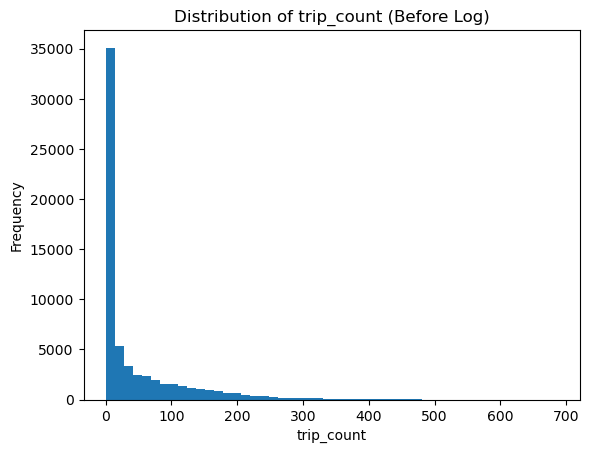

In [14]:
plt.hist(train_df['trip_count'], bins=50)
plt.title('Distribution of trip_count (Before Log)')
plt.xlabel('trip_count')
plt.ylabel('Frequency')
plt.show()

**Observations:**
- The plot displays the raw distribution of trip_count in the training data, prior to applying a log transformation
- The training data shows a clear right-skew, with a very heavy concentration near 0 and a long tail
- This suggests most zone-hour combinations have low demand, while a small number experience very high trip volumes
- The extreme skew and variance make trip_count a strong candidate for a log1p transformation, which helps compress the long tail, stabilize variance, and improve model performance

#### Evaluate baseline data

In [15]:
# Compute average trip count per (pickup_zone, pickup_hour) in January
zone_hour_avg = train_df.groupby(['pickup_zone', 'pickup_hour'])['trip_count'].mean().reset_index()
zone_hour_avg.columns = ['pickup_zone', 'pickup_hour', 'baseline_pred']

In [16]:
# Merge with February test set
test_df = test_df.merge(zone_hour_avg, on=['pickup_zone', 'pickup_hour'], how='left')

In [17]:
test_df.shape

(58496, 23)

In [18]:
# Fill any missing predictions with overall January average
global_avg = train_df['trip_count'].mean()
test_df['baseline_pred'].fillna(global_avg, inplace=True)

/var/folders/jx/f68bh07x2yj9wm1y4w06hh040000gn/T/ipykernel_48701/3044719067.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['baseline_pred'].fillna(global_avg, inplace=True)


In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(test_df['trip_count'], test_df['baseline_pred'])
rmse = np.sqrt(mse)
r2 = r2_score(test_df['trip_count'], test_df['baseline_pred'])

print(f"Baseline RMSE: {rmse:.2f}")
print(f"Baseline R²: {r2:.2f}")

Baseline RMSE: 27.93
Baseline R²: 0.86


**Observations:**
- On average, the baseline model's predictions are off by about 28 trips
- An RMSE of 28 suggests high absolute error for low-demand zones and stronger performance in high demand zones
- 86% of variance in trip_count is explained by the baseline model. This is a strong score, indicating that the model is capturing much of the signal in the data, even before applying a log transformation


In [20]:
# Drop baseline column after evaluation
test_df.drop(columns=['baseline_pred'], inplace=True)


#### Log transformation

In [21]:
train_df['log_trip_count'] = np.log1p(train_df['trip_count'])
test_df['log_trip_count'] = np.log1p(test_df['trip_count'])

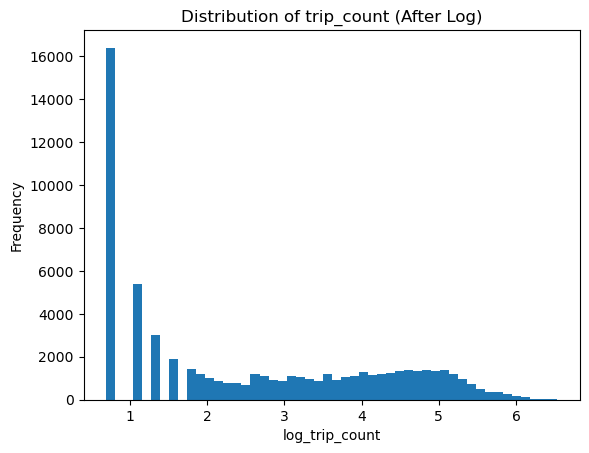

In [22]:
plt.hist(train_df['log_trip_count'], bins=50)
plt.title('Distribution of trip_count (After Log)')
plt.xlabel('log_trip_count')
plt.ylabel('Frequency')
plt.show()

**Observations:**
- The plot shows the distribution of trip_count after applying a log1p transformation
- Compared to the raw distribution, the data is now significantly less skewed and more spread out across the value range
- While a large spike still exists near log_trip_count = 1 (i.e., trip_count = 0), the rest of the distribution is more uniform and closer to symmetric, particularly in the range of 2 to 5
- The transformation compresses the long tail of high trip counts and stretches out the lower end, allowing the model to learn patterns across both high and low-demand zones more evenly

#### Define Target and Features

In [23]:
# Define target and features
target_column = 'log_trip_count'

# Step 1: Create log-transformed target columns
train_df['log_trip_count'] = np.log1p(train_df['trip_count'])
test_df['log_trip_count'] = np.log1p(test_df['trip_count'])

# Step 2: Drop raw trip_count (optional but cleaner)
X_train = train_df.drop(columns=['trip_count', target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=['trip_count', target_column])
y_test = test_df[target_column]

# Step 3: Add log_trip_count back if needed for encoding or merging
X_train_full = X_train.copy()
X_train_full[target_column] = y_train

X_test_full = X_test.copy()
X_test_full[target_column] = y_test

#### Encoding

In [24]:
# Base encoding 
def base_encode(df):
    df_encoded = df.copy()
    df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)
    time_order = {
        'Early Morning': 0, 'Morning Rush': 1, 'Midday': 2, 'Evening Rush': 3, 'Night': 4
    }
    df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
    df_encoded.drop('time_of_day', axis=1, inplace=True)
    
    # One-hot encoding for pickup_borough and day_type
    df_encoded = pd.get_dummies(df_encoded, columns=['pickup_borough', 'day_type'], drop_first=False)
    return df_encoded

#  Target Encoding 
def target_encode_train_and_apply(train_df, test_df, target_column, zone_column):
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in zone_column:
        new_col = f"{col}_target_encoded"
        train_encoded[new_col] = np.nan
        for train_idx, val_idx in kf.split(train_df):
            train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
            means = train_fold.groupby(col)[target_column].mean()
            train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)
        final_means = train_df.groupby(col)[target_column].mean()
        test_encoded[new_col] = test_df[col].map(final_means)
        train_encoded.drop(columns=col, inplace=True)
        test_encoded.drop(columns=col, inplace=True)
    return train_encoded, test_encoded


#  Base encode the full data with target temporarily added
train_base = base_encode(X_train_full)
test_base = base_encode(X_test_full)

#  Target encode the zone columns
train_encoded, test_encoded = target_encode_train_and_apply(
    train_base, test_base,
    target_column='log_trip_count',
    zone_column=['pickup_zone', 'day_time_interaction', 'zone_hour_interaction', 'holiday_time_interaction', 'zone_isweekend_interaction', 'hour_isweekend_interaction', 'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction', 'zone_hour_holiday_interaction']
)

In [25]:
#  Drop datetime columns
for col in ['pickup_date', 'tpep_pickup_datetime']:
    train_encoded.drop(columns=col, errors='ignore', inplace=True)
    test_encoded.drop(columns=col, errors='ignore', inplace=True)

#  NOW drop the target from the features
X_train_final = train_encoded.drop(columns=['log_trip_count'])
X_test_final = test_encoded.drop(columns=['log_trip_count'])

# Final check
print("Final training columns:", X_train_final.columns)

Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'is_holiday', 'trip_count_1h_ago', 'trip_count_2h_ago',
       'rolling_avg_2h', 'time_of_day_encoded', 'pickup_borough_Bronx',
       'pickup_borough_Brooklyn', 'pickup_borough_EWR',
       'pickup_borough_Manhattan', 'pickup_borough_Queens',
       'pickup_borough_Staten Island', 'day_type_Weekday', 'day_type_Weekend',
       'pickup_zone_target_encoded', 'day_time_interaction_target_encoded',
       'zone_hour_interaction_target_encoded',
       'holiday_time_interaction_target_encoded',
       'zone_isweekend_interaction_target_encoded',
       'hour_isweekend_interaction_target_encoded',
       'zone_time_isweekend_interaction_target_encoded',
       'zone_hour_isweekend_interaction_target_encoded',
       'zone_hour_holiday_interaction_target_encoded'],
      dtype='object')


#### Train and Evaluate Random Forrest

##### Random Forrest using cv = 3

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
Evaluation on Test Set (in original trip_count scale):
RMSE: 13.34
MAE: 6.41
R² Score: 0.9679


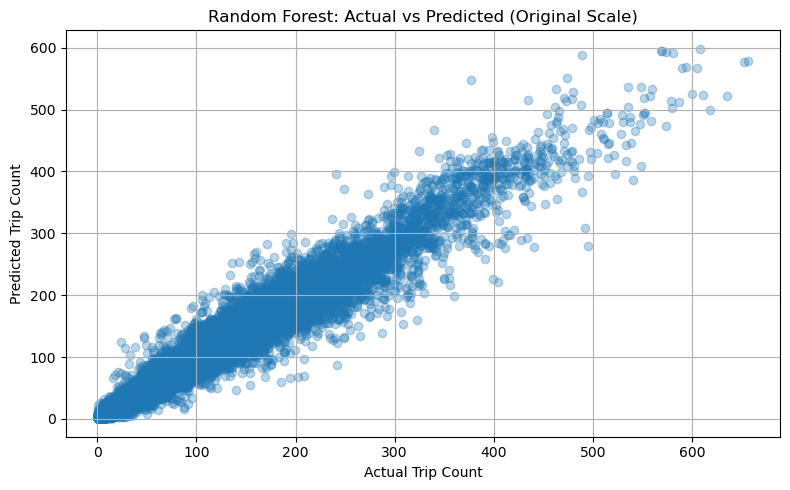

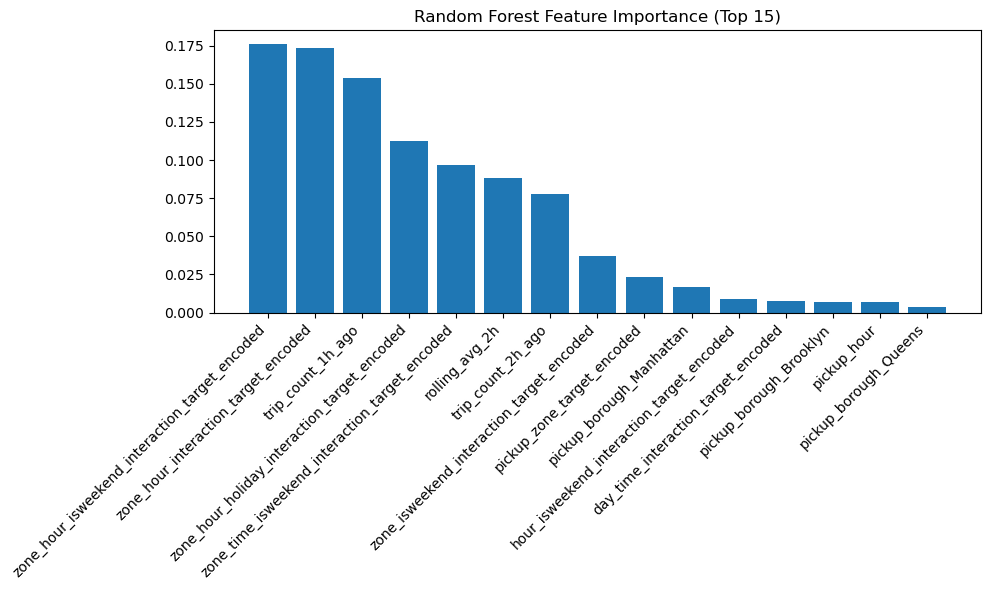

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

log_preds = best_model.predict(X_test)
y_pred = np.expm1(log_preds)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (in original trip_count scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("Random Forest: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance (Top 15)")
plt.bar(range(15), importances[indices[:15]])
plt.xticks(range(15), [features[i] for i in indices[:15]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Evaluation:** 
| Metric       | Value | Assessment                                              |
| ------------ | ----- | ------------------------------------------------------- |
| **RMSE**     | 13.34 | Very low error — good predictive precision              |
| **MAE**      | 6.41  | Strong — indicates stable performance, low average miss |
| **R² Score** | 0.968 | Excellent — explains \~97% of variance in trip counts   |


**Feature Importance (Top 15)**
- The most important features are all time-zone interactions and target-encoded categorical variables, highlighting the importance of both spatial and temporal patterns in predicting demand
- Top contributing features include:
    - zone_hour_isweekend_interaction_target_encoded
    - zone_hour_interaction_target_encoded
    - trip_count_1h_ago
- Lag features (trip_count_1h_ago, trip_count_2h_ago) and rolling averages also rank highly, showing that recent demand history is a strong signal
- Pickup boroughs and hour contributed less to to model performance, especially when not part of engineered interactions

##### Random Forrest using cv = 5

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/envs/taxi_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
Evaluation on Test Set (in original trip_count scale):
RMSE: 13.36
MAE: 6.41
R² Score: 0.9678


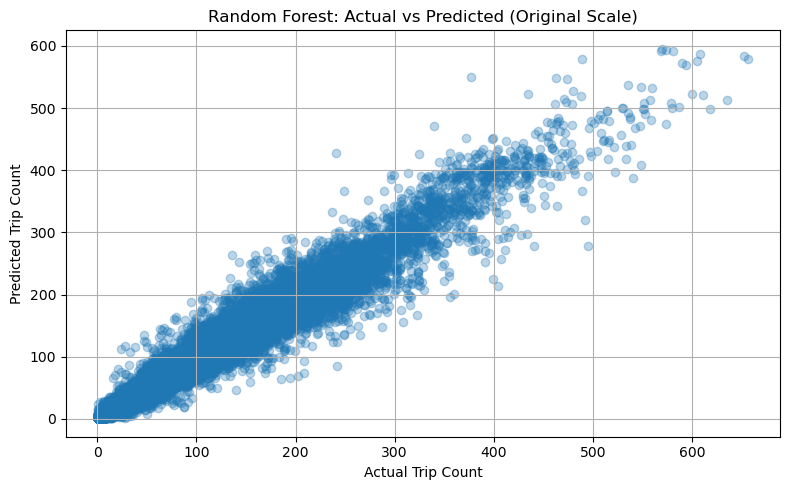

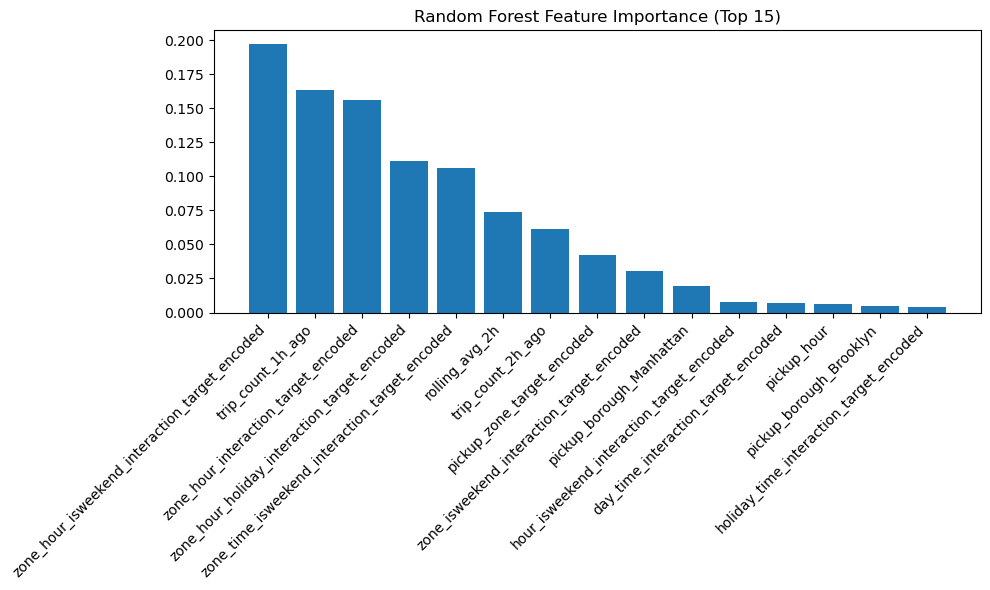

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

log_preds = best_model.predict(X_test)
y_pred = np.expm1(log_preds)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (in original trip_count scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("Random Forest: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance (Top 15)")
plt.bar(range(15), importances[indices[:15]])
plt.xticks(range(15), [features[i] for i in indices[:15]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### **Evaluation**
| Metric       | Value  | Comment                                   |
| ------------ | ------ | ----------------------------------------- |
| **RMSE**     | 13.36  | Matches CV=3 — very low error             |
| **MAE**      | 6.41   | Consistent with earlier model             |
| **R² Score** | 0.9678 | Still strong — no overfitting detected |

| Setting | RMSE  | MAE  | R²     | Notes                     |
| ------- | ----- | ---- | ------ | ------------------------- |
| CV = 3  | 13.34 | 6.41 | 0.968 | Slightly simpler (faster) |
| CV = 5  | 13.36 | 6.41 | 0.9678 | More robust, same result  |

| Rank | Feature Name                                      | Description                                                             |
|------|---------------------------------------------------|-------------------------------------------------------------------------|
| 1    | `zone_hour_isweekend_interaction_target_encoded`  | Captures zone-hour-weekend interactions; strongest predictor of demand |
| 2    | `trip_count_1h_ago`                               | Trip demand one hour ago in the same zone — key temporal signal         |
| 3    | `zone_hour_interaction_target_encoded`            | Historical demand for zone-hour combinations                            |
| 4    | `zone_hour_holiday_interaction_target_encoded`    | Adjusts for holiday effects at the zone-hour level                      |
| 5    | `zone_time_isweekend_interaction_target_encoded`  | Weekend effect across zone and time-of-day                              |
| 6    | `zone_isweekend_interaction_target_encoded`       | Overall weekend shift by zone                                           |
| 7    | `rolling_avg_2h`                                  | Smoothed average demand over previous 2 hours                           |
| 8    | `trip_count_2h_ago`                               | Trip demand two hours ago                                               |
| 9    | `pickup_zone_target_encoded`                      | Average historical demand for the pickup zone                           |
| 10   | `pickup_borough_Manhattan`                        | Indicator for pickups in Manhattan                                      |
| 11   | `zone_isweekend_interaction_target_encoded`       | Duplicate of Rank 6 — may be due to encoding redundancy                 |
| 12   | `pickup_borough_Brooklyn`                         | Indicator for pickups in Brooklyn                                       |
| 13   | `pickup_hour`                                     | Raw pickup hour — less predictive than temporal interactions            |
| 14   | `day_time_interaction_target_encoded`             | Day-of-week × time-of-day demand pattern                                |
| 15   | `holiday_time_interaction_target_encoded`         | Captures holiday-specific time effects                                  |


#### Train and Evaluate XGBoost

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Evaluation on Test Set (Original Scale):
RMSE: 15.24
MAE: 7.14
R² Score: 0.9581


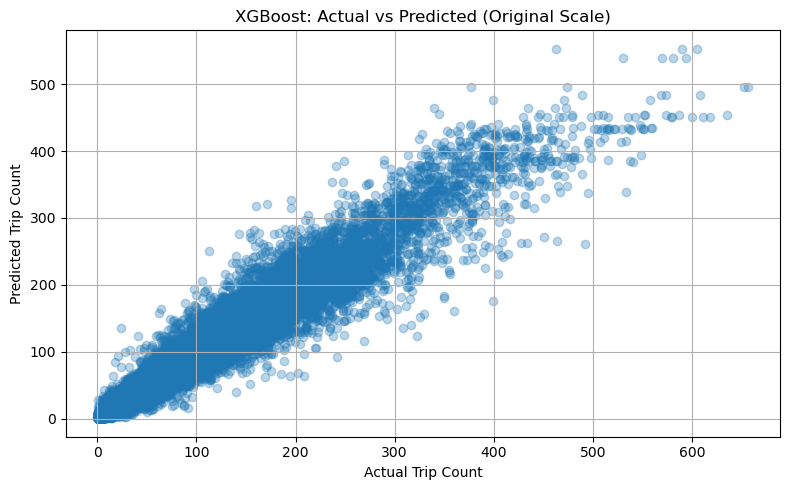

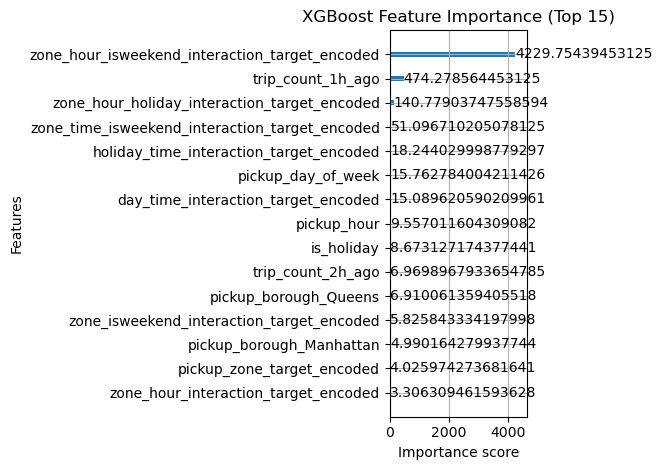

In [28]:
from xgboost import XGBRegressor, plot_importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    verbosity=0,
    random_state=42
)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

log_preds = best_model.predict(X_test)
y_pred = np.expm1(log_preds)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (Original Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("XGBoost: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

plot_importance(best_model, max_num_features=15, importance_type='gain')
plt.title("XGBoost Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


##### **Evaluation**
| Metric       | Value  | Comment                                   |
| ------------ | ------ | ----------------------------------------- |
| **RMSE**     | 15.24  | Slightly higher than RF; still low error  |
| **MAE**      | 7.14   | Acceptable — good consistency across bins |
| **R² Score** | 0.9581 | Strong fit — mild drop vs. RF, no overfit |


In [29]:
# Prepare data (already encoded)
X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

# Define XGBoost model
model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    verbosity=0,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
log_preds = best_model.predict(X_test)

# Inverse log-transform
y_pred = np.expm1(log_preds)
y_true = np.expm1(y_test)

# Evaluation
print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (Original Scale):")
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

# Absolute error
errors = np.abs(y_true - y_pred)

# Scatter plot colored by absolute error
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    y_true, y_pred,
    c=errors,
    cmap='coolwarm',
    alpha=0.6,
    edgecolor='k'
)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("XGBoost: Actual vs Predicted (Colored by Absolute Error)")
plt.colorbar(scatter, label='Absolute Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
plot_importance(best_model, max_num_features=15, importance_type='gain')
plt.title("XGBoost Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Evaluation on Test Set (Original Scale):


TypeError: got an unexpected keyword argument 'squared'

#### Train and Evaluate LightGBM

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Evaluation on Test Set (Original Scale):
RMSE: 15.07
MAE: 7.09
R² Score: 0.9591


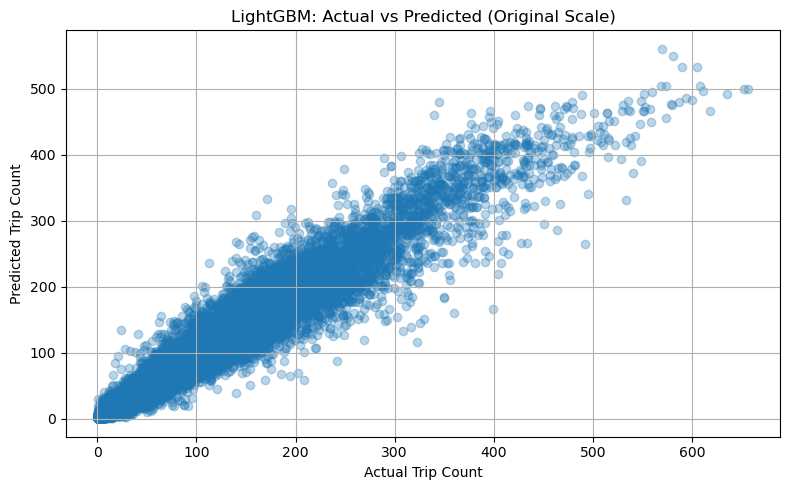

<Figure size 800x600 with 0 Axes>

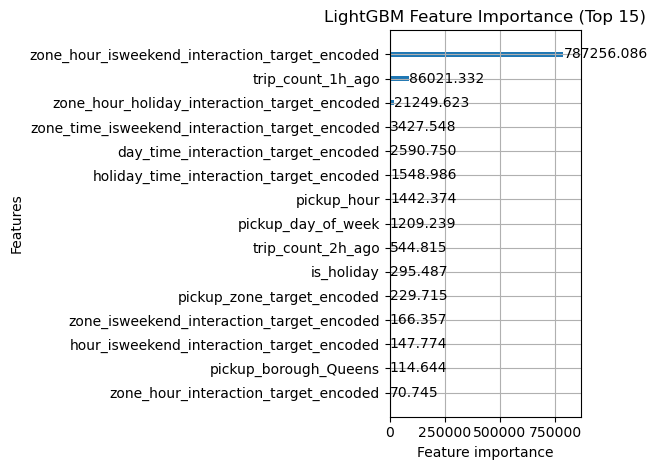

In [62]:
from lightgbm import LGBMRegressor, plot_importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

model = LGBMRegressor(
    objective='regression',
    verbosity=-1,
    random_state=42
)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

log_preds = best_model.predict(X_test)
y_pred = np.expm1(log_preds)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (Original Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("LightGBM: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plot_importance(best_model.booster_, max_num_features=15, importance_type='gain')
plt.title("LightGBM Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


##### **Evaluation**
| Metric       | Value  | Comment                                   |
| ------------ | ------ | ----------------------------------------- |
| **RMSE**     | 15.07  | Slightly higher than RF; still low error  |
| **MAE**      | 7.09   | Consistent and stable across predictions  |
| **R² Score** | 0.9591 | Strong fit — close to XGBoost, no overfit |


##### **Evaluation (Conclusion)**
- All models achieve high accuracy, each explaining over 95–97% of the variance in trip demand.
- Random Forest relies more on lag features and raw temporal variables, while boosting models (XGBoost and LightGBM) leverage target-encoded interaction patterns more effectively.
- LightGBM is selected for final deployment due to its strong balance of:
  - **Predictive performance** (RMSE = 15.07, R² = 0.9591)
  - **Training speed and scalability** — optimized for large tabular datasets
  - **Native support for missing values** and **categorical features**
  - **Compatibility with SHAP** and feature importance tools for model interpretability
- The consistency across all models reinforces that recent demand signals and zone-hour context are the most influential predictors of taxi activity across NYC.